In [ ]:
import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.image import resize
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score,accuracy_score, recall_score, f1_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Define your folder structure
data_dir = '/content/drive/MyDrive/PhysioNet2021/Data'
classes = ['Abnormal', 'Normal']

# Load and preprocess audio data
def load_and_preprocess_data(data_dir, classes, target_shape=(128, 128)):
    data = []
    labels = []

    for i, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.endswith('.wav'):
                file_path = os.path.join(class_dir, filename)
                audio_data, sample_rate = librosa.load(file_path, sr=16000)
                # Perform preprocessing (e.g., convert to Mel spectrogram and resize)
                mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
                mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to dB scale
                mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), target_shape)
                data.append(mel_spectrogram)
                labels.append(i)

    return np.array(data), np.array(labels)

In [ ]:

# Split data into training and testing sets
data, labels = load_and_preprocess_data(data_dir, classes)
labels = to_categorical(labels, num_classes=len(classes))  # Convert labels to one-hot encoding

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_f1 = 0
best_model = None
best_history = None
best_y_true = None
best_y_pred = None
best_fold = None
fold_accuracies = []
fold_precisions = []
fold_recalls = []
fold_f1s = []

fold = 1
for train_index, test_index in skf.split(data, np.argmax(labels, axis=1)):
    print(f"\nTraining Fold {fold}...")

    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    input_layer = Input(shape=X_train[0].shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output_layer = Dense(len(classes), activation='softmax')(x)
    model = Model(input_layer, output_layer)
    plot_model(model, to_file='custom_cnn.png', show_shapes=True, show_layer_names=True)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                        validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=0)

    # Evaluate
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    fold_accuracies.append(accuracy)
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_f1s.append(f1)

    if f1 > best_f1:
        best_f1 = f1
        best_model = model
        best_history = history
        best_y_true = y_true
        best_y_pred = y_pred
        best_fold = fold

    print(f"Fold {fold} F1-Score: {f1:.4f}")
    fold += 1

# === After all folds === #
print("\n Cross-validation complete.")
print("=== Average Metrics Across Folds ===")
print(f"Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Precision: {np.mean(fold_precisions):.4f}")
print(f"Recall: {np.mean(fold_recalls):.4f}")
print(f"F1 Score: {np.mean(fold_f1s):.4f}")

print(f"\nBest Fold: {best_fold} with F1-Score: {best_f1:.4f}")



Training Fold 1...
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Fold 1 F1-Score: 0.7099

Training Fold 2...
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Fold 2 F1-Score: 0.8408

Training Fold 3...
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 3 F1-Score: 0.7128

Training Fold 4...
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold 4 F1-Score: 0.7128

Training Fold 5...
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
Fold 5 F1-Score: 0.8436

 Cross-validation complete.
=== Average Metrics Across Folds ===
Accuracy: 0.8117
Precision: 0.7373
Recall: 0.8117
F1 Score: 0.7640

Best Fold: 5 with F1-Score: 0.8436


In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots training and validation loss & accuracy from a Keras model history object.

    Args:
        history: Keras History object from model.fit()
    """
    # Create subplots for Loss and Accuracy
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Loss Plot
    ax[0].plot(history.history['loss'], label='Training Loss', color='blue')
    ax[0].plot(history.history['val_loss'], label='Validation Loss', color='red')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].legend()

    # Accuracy Plot
    ax[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
    ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].legend()

    # Show the plots
    plt.show()


In [ ]:

# Compute and display confusion matrix
conf_matrix = confusion_matrix(best_y_true, best_y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Print Full Classification Report
print("Classification Report:\n", classification_report(best_y_true, best_y_pred, zero_division=0, target_names=classes))

Confusion Matrix:
 [[114  14]
 [ 95 420]]
Classification Report:
               precision    recall  f1-score   support

    Abnormal       0.55      0.89      0.68       128
      Normal       0.97      0.82      0.89       515

    accuracy                           0.83       643
   macro avg       0.76      0.85      0.78       643
weighted avg       0.88      0.83      0.84       643



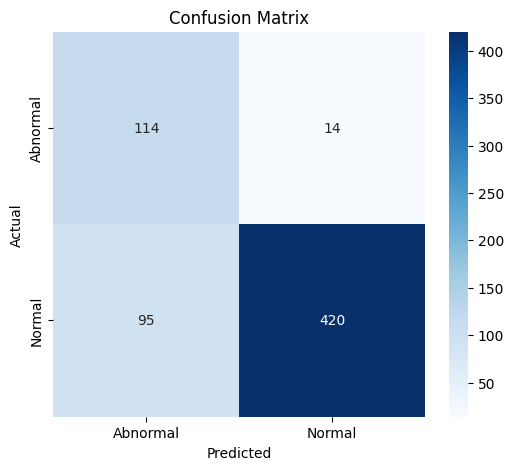

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(best_y_true, best_y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

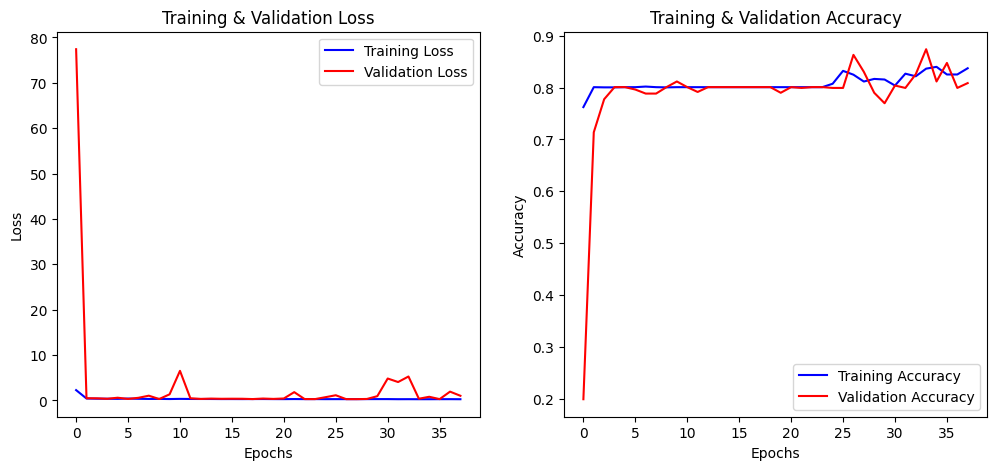

In [ ]:
# Plot training performance
plot_training_history(best_history)

In [ ]:
# Define function to preprocess and classify an unseen audio file
def test_audio(file_path, model):
    # Load and preprocess the audio file
    audio_data, sample_rate = librosa.load(file_path, sr=16000)

    # Extract log Mel-spectrogram (MATCH TRAINING PREPROCESSING)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to log scale

    # Resize to match training shape
    mel_spectrogram = resize(np.expand_dims(mel_spectrogram, axis=-1), (128, 128))
    mel_spectrogram = tf.reshape(mel_spectrogram, (1, 128, 128, 1))  # Ensure batch dimension

    # Make predictions
    predictions = model.predict(mel_spectrogram)

    # Get the class probabilities
    class_probabilities = predictions[0]

    # Get the predicted class index
    predicted_class_index = np.argmax(class_probabilities)

    return class_probabilities, predicted_class_index

# Example: Test an unseen audio file
test_audio_file = "/content/c0003.wav"
class_probabilities, predicted_class_index = test_audio(test_audio_file, model)

# Display results for all classes
for i, class_label in enumerate(classes):
    probability = class_probabilities[i]
    print(f"Class: {class_label}, Probability: {probability:.4f}")

# Display final classification
predicted_class = classes[predicted_class_index]
confidence = class_probabilities[predicted_class_index]
print(f"The audio is classified as: {predicted_class}")
print(f"Confidence Score: {confidence:.4f}")


<ipython-input-9-9c9dd60776c7>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_data, sample_rate = librosa.load(file_path, sr=16000)
/usr/local/lib/python3.11/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


FileNotFoundError: [Errno 2] No such file or directory: '/content/c0003.wav'

In [ ]:
# Save the model
model.save('Best_RandomState_audio_classification_model.keras')

In [ ]:
import librosa
import numpy as np
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt
import os

# Function to extract Mel spectrogram features
def extract_mel_spectrogram(file_path, sr=16000, n_mels=64, hop_length=512):
    # Load audio file and resample to 16kHz
    audio_data, _ = librosa.load(file_path, sr=sr)

    # Compute Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr, n_mels=n_mels, hop_length=hop_length)

    # Convert to log scale (better for CNNs)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    return mel_spectrogram

# Example Usage:
file_path = "/content/c0002.wav"
mel_spec = extract_mel_spectrogram(file_path)

# Display Mel Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=16000, hop_length=512, cmap='viridis')
plt.colorbar(label='dB')
plt.title("Mel Spectrogram for Abnormal")
plt.show()

# Example Usage:
file_path = "/content/c0003.wav"
mel_spec = extract_mel_spectrogram(file_path)

# Display Mel Spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec, sr=16000, hop_length=512, cmap='viridis')
plt.colorbar(label='dB')
plt.title("Mel Spectrogram for Normal")
plt.show()

